<a href="https://colab.research.google.com/github/parmidamardi/CDM-TA-4/blob/main/CDM_TA_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(v):
    return 0.5 * v.T @ H @ v

In [4]:
#step 1.1

In [5]:
def grad(v):
    return H @ v

In [6]:
def gradient_descent(theta0, lr=0.02, iters=50):
    theta = theta0.copy()
    trajectory = [theta.copy()]

    for _ in range(iters):
        g = grad(theta)
        theta = theta - lr * g
        trajectory.append(theta.copy())

    return np.array(trajectory)

In [7]:
H_inv = np.linalg.inv(H)

def newton_method(theta0, iters=10):
    theta = theta0.copy()
    trajectory = [theta.copy()]

    for _ in range(iters):
        g = grad(theta)
        theta = theta - H_inv @ g
        trajectory.append(theta.copy())

    return np.array(trajectory)


In [8]:
def conjugate_gradient(theta0, iters=10):
    theta = theta0.copy()
    trajectory = [theta.copy()]

    r = grad(theta)
    p = -r

    for _ in range(iters):
        Hp = H @ p
        alpha = (r.T @ r) / (p.T @ Hp)

        theta = theta + alpha * p
        trajectory.append(theta.copy())

        r_new = r + alpha * Hp
        beta = (r_new.T @ r_new) / (r.T @ r)

        p = -r_new + beta * p
        r = r_new

    return np.array(trajectory)

In [9]:
#step 1.2

In [10]:
import matplotlib.pyplot as plt

In [11]:
theta0 = np.array([1.5, 1.0])

In [12]:
gd_traj = gradient_descent(theta0, lr=0.02, iters=40)
nt_traj = newton_method(theta0, iters=5)
cg_traj = conjugate_gradient(theta0, iters=10)

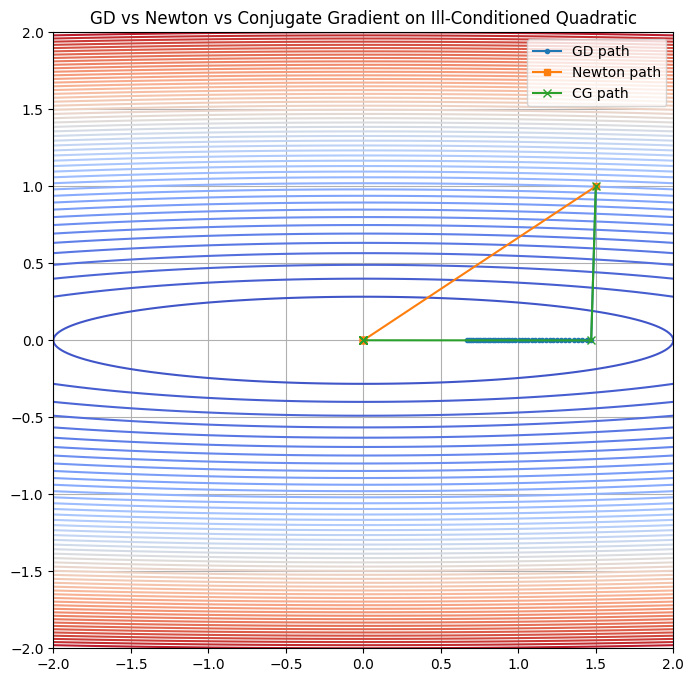

In [13]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (X**2 + 50 * Y**2)

plt.figure(figsize=(8,8))
plt.contour(X, Y, Z, levels=50, cmap='coolwarm')

# GD
plt.plot(gd_traj[:,0], gd_traj[:,1], 'o-', label='GD path', markersize=3)

# Newton
plt.plot(nt_traj[:,0], nt_traj[:,1], 's-', label='Newton path', markersize=5)

# Conjugate Gradient
plt.plot(cg_traj[:,0], cg_traj[:,1], 'x-', label='CG path', markersize=6)

plt.legend()
plt.title("GD vs Newton vs Conjugate Gradient on Ill-Conditioned Quadratic")
plt.grid(True)
plt.show()

In [14]:
#section 2

In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
data = load_breast_cancer()
X = data.data
y = data.target

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
y = y.reshape(-1, 1)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [20]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (455, 30) (455, 1)
Test shape: (114, 30) (114, 1)


In [21]:
# architecture
input_dim = 30
hidden_dim = 5
output_dim = 1

In [22]:
W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
b1 = np.zeros((1, hidden_dim))


In [23]:
W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
b2 = np.zeros((1, output_dim))

In [24]:
total_params = (
    W1.size + b1.size +
    W2.size + b2.size
)

print("Total parameters:", total_params)


Total parameters: 161


In [25]:
def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(X):
    z1 = X @ W1 + b1
    h1 = relu(z1)
    z2 = h1 @ W2 + b2
    y_hat = sigmoid(z2)
    cache = (z1, h1, z2, y_hat)
    return y_hat, cache

In [26]:
def loss_fn(y_hat, y):
    eps = 1e-8
    return -np.mean(y * np.log(y_hat + eps) +
                    (1 - y) * np.log(1 - y_hat + eps))


In [27]:
def backward(X, y, cache):
    z1, h1, z2, y_hat = cache
    m = X.shape[0]

    dz2 = (y_hat - y) / m
    dW2 = h1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    dh1 = dz2 @ W2.T
    dz1 = dh1 * relu_grad(z1)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    grads = (dW1, db1, dW2, db2)
    return grads


In [28]:
def pack_params(W1, b1, W2, b2):
    return np.concatenate([
        W1.ravel(),
        b1.ravel(),
        W2.ravel(),
        b2.ravel()
    ])

In [29]:
def unpack_params(theta, input_dim=30, hidden_dim=5, output_dim=1):
    p1 = input_dim * hidden_dim
    p2 = hidden_dim
    p3 = hidden_dim * output_dim
    p4 = output_dim

    W1 = theta[:p1].reshape(input_dim, hidden_dim)
    b1 = theta[p1:p1+p2].reshape(1, hidden_dim)
    W2 = theta[p1+p2:p1+p2+p3].reshape(hidden_dim, output_dim)
    b2 = theta[p1+p2+p3:].reshape(1, output_dim)

    return W1, b1, W2, b2

In [30]:
def loss_and_grad(theta, X, y):
    W1, b1, W2, b2 = unpack_params(theta)

    z1 = X @ W1 + b1
    h1 = relu(z1)
    z2 = h1 @ W2 + b2
    y_hat = sigmoid(z2)

    eps = 1e-8
    loss = -np.mean(y*np.log(y_hat+eps) + (1-y)*np.log(1-y_hat+eps))

    m = X.shape[0]
    dz2 = (y_hat - y) / m
    dW2 = h1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    dh1 = dz2 @ W2.T
    dz1 = dh1 * relu_grad(z1)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    grad = pack_params(dW1, db1, dW2, db2)
    return loss, grad


def loss_only(theta, X, y):
    return loss_and_grad(theta, X, y)[0]

def grad_only(theta, X, y):
    return loss_and_grad(theta, X, y)[1]


In [31]:
#step 2.2

In [32]:
import time
from scipy.optimize import minimize

In [33]:
theta_init = pack_params(W1, b1, W2, b2)
theta_init.shape

(161,)

In [34]:
def train_sgd(theta_init, X, y, lr=0.01, epochs=200):
    theta = theta_init.copy()
    losses = []
    times = []

    start = time.time()
    for ep in range(epochs):
        loss, grad = loss_and_grad(theta, X, y)
        theta = theta - lr * grad

        losses.append(loss)
        times.append(time.time() - start)

    return theta, losses, times


In [35]:
def train_lbfgs(theta_init, X, y, max_iter=200):
    loss_hist = []
    time_hist = []
    start = time.time()

    def callback(th):
        loss = loss_only(th, X, y)
        loss_hist.append(loss)
        time_hist.append(time.time() - start)

    result = minimize(
        fun=lambda th: loss_only(th, X, y),
        x0=theta_init,
        jac=lambda th: grad_only(th, X, y),
        method='L-BFGS-B',
        callback=callback,
        options={'maxiter': max_iter}
    )

    theta_opt = result.x
    return theta_opt, loss_hist, time_hist


In [36]:
def train_cg(theta_init, X, y, max_iter=200):
    loss_hist = []
    time_hist = []
    start = time.time()

    def callback(th):
        loss = loss_only(th, X, y)
        loss_hist.append(loss)
        time_hist.append(time.time() - start)

    result = minimize(
        fun=lambda th: loss_only(th, X, y),
        x0=theta_init,
        jac=lambda th: grad_only(th, X, y),
        method='CG',
        callback=callback,
        options={'maxiter': max_iter}
    )

    theta_opt = result.x
    return theta_opt, loss_hist, time_hist


In [37]:
theta_sgd, L_sgd, T_sgd = train_sgd(theta_init, X_train, y_train,
                                    lr=0.01, epochs=200)

theta_lbfgs, L_lbfgs, T_lbfgs = train_lbfgs(theta_init, X_train, y_train,
                                            max_iter=200)

theta_cg, L_cg, T_cg = train_cg(theta_init, X_train, y_train,
                                max_iter=200)


/tmp/ipython-input-3534777314.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


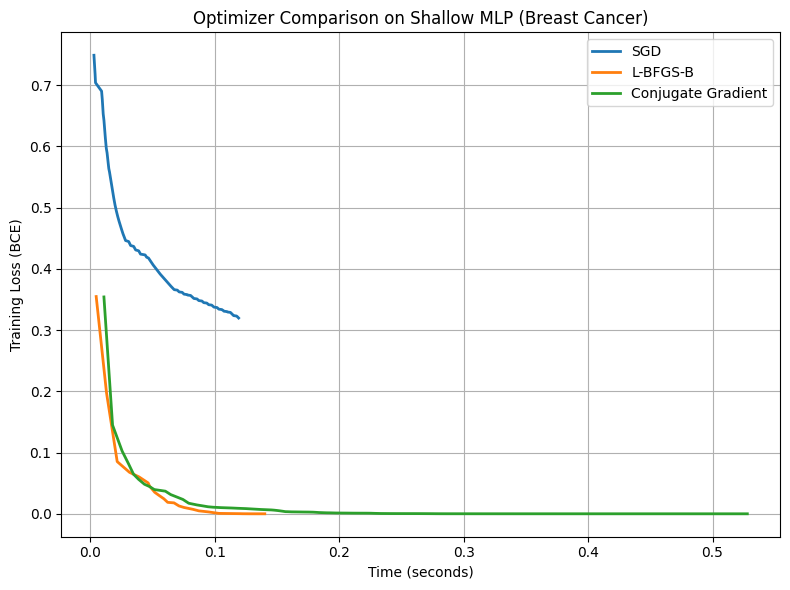

In [38]:
# step 2.3

plt.figure(figsize=(8, 6))

plt.plot(T_sgd,   L_sgd,   label="SGD",              linewidth=2)
plt.plot(T_lbfgs, L_lbfgs, label="L-BFGS-B",         linewidth=2)
plt.plot(T_cg,    L_cg,    label="Conjugate Gradient", linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Training Loss (BCE)")
plt.title("Optimizer Comparison on Shallow MLP (Breast Cancer)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
#step 3.1

In [40]:
from tensorflow.keras.datasets import mnist, fashion_mnist

use_fashion = False

if use_fashion:
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
else:
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(len(X_train), -1) / 255.0
X_test  = X_test.reshape(len(X_test), -1) / 255.0

print("Train:", X_train.shape)
print("Test:", X_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 784)
Test: (10000, 784)


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, Model

input_dim = 784

inputs = layers.Input(shape=(input_dim,))
h1 = layers.Dense(100, activation='relu')(inputs)
h2 = layers.Dense(100, activation='relu')(h1)
h3 = layers.Dense(100, activation='relu')(h2)
outputs = layers.Dense(10, activation='softmax')(h3)

deep_model = Model(inputs, outputs)

deep_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
#step 3.3

In [43]:
import time
from tensorflow.keras import optimizers

In [44]:
initial_weights = deep_model.get_weights()


In [45]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self._epoch_start_time = None
        self._t0 = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t_epoch = time.time() - self._epoch_start_time
        self.epoch_times.append(t_epoch)

In [46]:
def train_with_optimizer(optimizer, epochs=10, batch_size=128):

    model = tf.keras.models.clone_model(deep_model)
    model.build((None, 784))
    model.set_weights(initial_weights)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    time_cb = TimeHistory()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[time_cb]
    )

    losses = history.history['loss']
    times_cum = np.cumsum(time_cb.epoch_times)

    return model, losses, times_cum

In [47]:
EPOCHS = 10
BATCH_SIZE = 128

sgd_optimizer = optimizers.SGD(learning_rate=0.01)
model_sgd, loss_sgd, time_sgd = train_with_optimizer(
    sgd_optimizer,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)
print("SGD training finished.")

SGD training finished.


In [48]:
adam_optimizer = optimizers.Adam(learning_rate=0.001)
model_adam, loss_adam, time_adam = train_with_optimizer(
    adam_optimizer,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)
print("Adam training finished.")

Adam training finished.


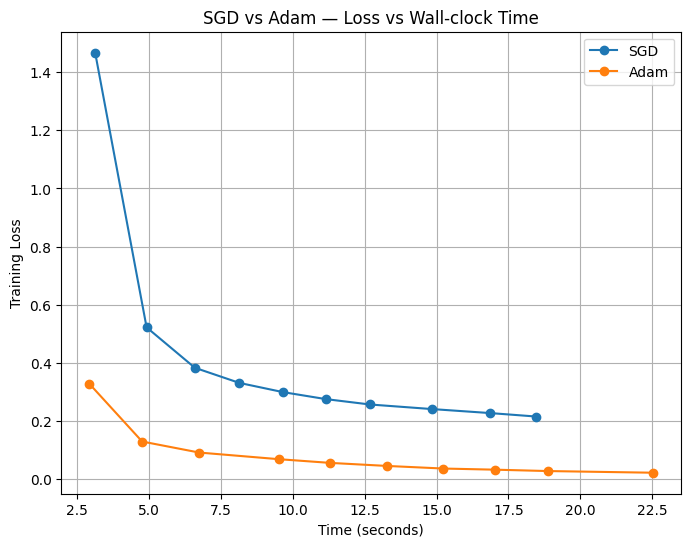

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(time_sgd, loss_sgd, marker='o', label='SGD')
plt.plot(time_adam, loss_adam, marker='o', label='Adam')
plt.xlabel("Time (seconds)")
plt.ylabel("Training Loss")
plt.title("SGD vs Adam — Loss vs Wall-clock Time")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#step 4.1

In [51]:
from sklearn.datasets import fetch_openml

In [52]:
data = fetch_openml(name="boston", version=1, as_frame=True)
X = data.data.values
y = data.target.values
feature_names = data.feature_names

print("X shape:", X.shape)
print("y shape:", y.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X shape: (506, 13)
y shape: (506,)


In [53]:
cov_matrix = np.cov(X_scaled, rowvar=False)


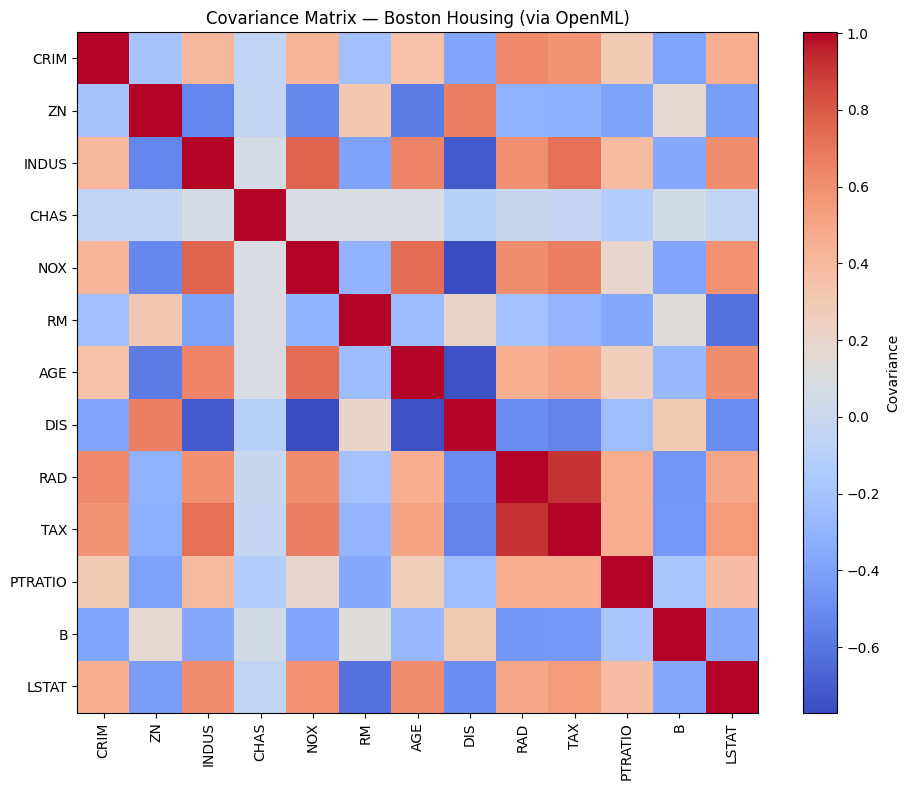

In [54]:
plt.figure(figsize=(10, 8))
plt.imshow(cov_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Covariance")
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)
plt.title("Covariance Matrix — Boston Housing (via OpenML)")
plt.tight_layout()
plt.show()

In [55]:
#step 4.2

In [56]:
Q, R = np.linalg.qr(X_scaled)


In [57]:
print("Shape of Q:", Q.shape)
print("Shape of R:", R.shape)

Shape of Q: (506, 13)
Shape of R: (13, 13)


In [58]:
orth_check = Q.T @ Q
X_ortho = Q
print("\nQ^T Q (should be close to I):")
print(orth_check)


Q^T Q (should be close to I):
[[ 1.00000000e+00  2.77555756e-17 -7.63278329e-17 -1.65882932e-17
  -4.85722573e-17 -3.46944695e-18  4.16333634e-17  1.04083409e-17
   4.16333634e-17  9.54097912e-18  2.03830008e-17 -1.22948526e-16
  -9.54097912e-18]
 [ 2.77555756e-17  1.00000000e+00  1.38777878e-17  4.85722573e-17
  -6.93889390e-18  1.90819582e-17  6.93889390e-18  5.55111512e-17
   5.55111512e-17  2.08166817e-17 -4.85722573e-17 -1.04083409e-17
   2.12503626e-17]
 [-7.63278329e-17  1.38777878e-17  1.00000000e+00 -1.04083409e-17
  -7.63278329e-17  5.29090660e-17  4.16333634e-17 -5.88179679e-17
   1.11022302e-16  9.71445147e-17 -6.93889390e-18  1.04083409e-17
   3.12250226e-17]
 [-1.65882932e-17  4.85722573e-17 -1.04083409e-17  1.00000000e+00
   2.77555756e-17  4.16333634e-17  1.04083409e-17 -6.24500451e-17
   5.01985606e-17 -1.64798730e-17  1.38777878e-17 -1.73472348e-17
  -1.38777878e-17]
 [-4.85722573e-17 -6.93889390e-18 -7.63278329e-17  2.77555756e-17
   1.00000000e+00  8.32667268e-17 -

In [59]:
#step 4.3

In [60]:
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

Xb = add_bias(X_scaled)
Qb = add_bias(Q)

In [61]:
def mse_loss(X, y, w):
    y_pred = X @ w
    return np.mean((y_pred - y)**2)

In [62]:
def train_sgd(X, y, lr=0.01, epochs=200, batch_size=32):
    n, d = X.shape
    w = np.zeros(d)
    losses = []

    for ep in range(epochs):
        perm = np.random.permutation(n)
        X = X[perm]
        y = y[perm]

        for i in range(0, n, batch_size):
            Xb = X[i:i+batch_size]
            yb = y[i:i+batch_size]

            grad = (2 / len(yb)) * Xb.T @ (Xb @ w - yb)
            w -= lr * grad

        losses.append(mse_loss(X, y, w))

    return w, losses

In [63]:
w_X, losses_X = train_sgd(Xb, y, lr=0.01, epochs=200)


In [64]:
w_Q, losses_Q = train_sgd(Qb, y, lr=0.01, epochs=200)


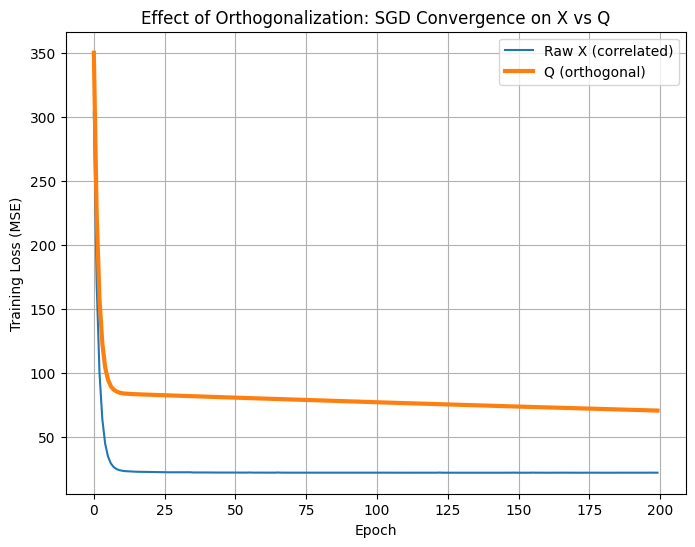

In [65]:
plt.figure(figsize=(8,6))
plt.plot(losses_X, label="Raw X (correlated)")
plt.plot(losses_Q, label="Q (orthogonal)", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Effect of Orthogonalization: SGD Convergence on X vs Q")
plt.grid(True)
plt.legend()
plt.show()

In [66]:
Q_norm = Q / np.linalg.norm(Q, axis=0, keepdims=True)

Qb_norm = add_bias(Q_norm)

print("Shape of Q_norm:", Q_norm.shape)
print("First column norm:", np.linalg.norm(Q_norm[:, 0]))

Shape of Q_norm: (506, 13)
First column norm: 1.0


In [67]:
w_Qnorm, losses_Qnorm = train_sgd(Qb_norm, y, lr=0.01, epochs=200)

len(losses_X), len(losses_Q), len(losses_Qnorm)


(200, 200, 200)

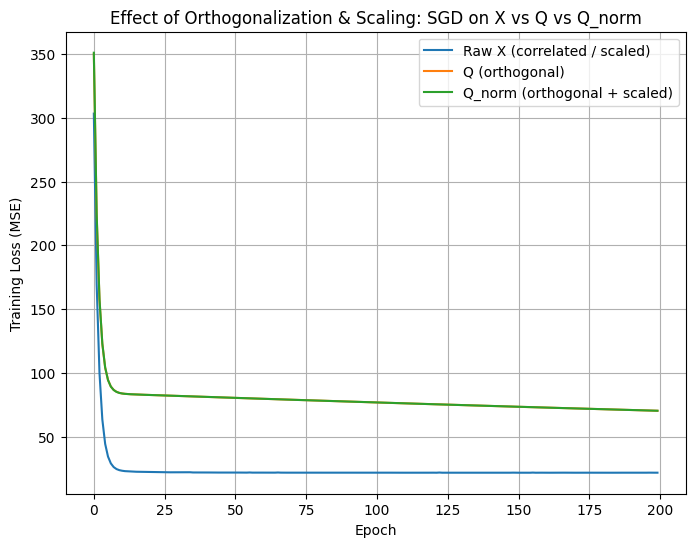

In [68]:
plt.figure(figsize=(8, 6))

plt.plot(losses_X,      label="Raw X (correlated / scaled)", color="C0")
plt.plot(losses_Q,      label="Q (orthogonal)",              color="C1")
plt.plot(losses_Qnorm,  label="Q_norm (orthogonal + scaled)",color="C2")

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Effect of Orthogonalization & Scaling: SGD on X vs Q vs Q_norm")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
#Add QR vs RawX experiment without normalization to isolate orthogonality effect

In [79]:
from sklearn.datasets import fetch_openml
import numpy as np

data = fetch_openml(name="boston", version=1)
X_raw = data.data.astype(float)
y     = data.target.astype(float)

In [80]:
Q, R = np.linalg.qr(X_raw)


In [81]:
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

Xb_raw = add_bias(X_raw)
Qb     = add_bias(Q)

In [82]:
def mse_loss(X, y, w):
    y_pred = X @ w
    return np.mean((y_pred - y)**2)

def train_sgd(X, y, lr=0.001, epochs=200, batch_size=32):
    n, d = X.shape
    w = np.zeros(d)
    losses = []

    for ep in range(epochs):
        perm = np.random.permutation(n)
        X = X[perm]
        y = y[perm]

        for i in range(0, n, batch_size):
            Xb = X[i:i+batch_size]
            yb = y[i:i+batch_size]

            grad = (2/len(yb)) * Xb.T @ (Xb @ w - yb)
            w -= lr * grad

        losses.append(mse_loss(X, y, w))

    return w, losses



In [85]:
w_raw, losses_raw = train_sgd(Xb_raw, y, lr=1e-7, epochs=200)
w_Q,   losses_Q   = train_sgd(Qb,     y, lr=0.01, epochs=200)


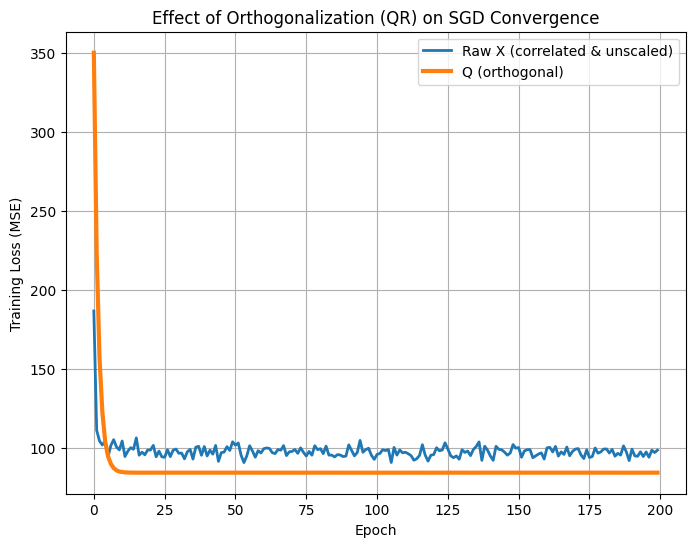

In [86]:
plt.figure(figsize=(8,6))
plt.plot(losses_raw, label="Raw X (correlated & unscaled)", linewidth=2)
plt.plot(losses_Q,   label="Q (orthogonal)", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Effect of Orthogonalization (QR) on SGD Convergence")
plt.grid(True)
plt.legend()
plt.show()
